In [9]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import nltk #For POS tagging
import sklearn #For generating some matrices
import pandas as pd#For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #MAkes the plots look nice

import pickle #if you want to save layouts
import os

%matplotlib inline

D:\computation\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
import pandas
nyt80s = pandas.read_csv('C:/Users/Alex/contentAnalysis/corporaTooLarge/nyt80sClean.csv')

In [3]:
display(nyt80s)

,article,date,tokenizedArticle,normalizedArticle
0,'79 food production in Vietnam was only 13....,January 2 1980,"[""'79"", 'food', 'production', 'in', 'Vietnam',...","['food', 'product', 'vietnam', 'onli', 'millio..."
1,"Karleton Armstrong, convicted of '70 bombin...",January 2 1980,"['Karleton', 'Armstrong', ',', 'convicted', 'o...","['karleton', 'armstrong', 'convict', 'bomb', '..."
2,Militants holding US diplomatic personnel h...,January 5 1980,"['Militants', 'holding', 'US', 'diplomatic', '...","['milit', 'hold', 'us', 'diplomat', 'personnel..."
3,Militants holding US diplomatic personnel h...,January 5 1980,"['Militants', 'holding', 'US', 'diplomatic', '...","['milit', 'hold', 'us', 'diplomat', 'personnel..."
4,China apparently concludes that best strate...,January 5 1980,"['China', 'apparently', 'concludes', 'that', '...","['china', 'appar', 'conclud', 'best', 'strateg..."
5,5 US chemical companies that produced milit...,January 7 1980,"['5', 'US', 'chemical', 'companies', 'that', '...","['us', 'chemic', 'compani', 'produc', 'militar..."
6,"Phnom Penh, Cambodia, celebrates 1st annive...",January 8 1980,"['Phnom', 'Penh', ',', 'Cambodia', ',', 'celeb...","['phnom', 'penh', 'cambodia', 'celebr', 'anniv..."
7,Australian Government agrees to form indepe...,January 8 1980,"['Australian', 'Government', 'agrees', 'to', '...","['australian', 'govern', 'agre', 'form', 'inde..."
8,"Warrant Officer Francis Anton, former Army ...",January 9 1980,"['Warrant', 'Officer', 'Francis', 'Anton', ','...","['warrant', 'offic', 'franci', 'anton', 'forme..."
9,Author Richard J Walton article on Soviet i...,January 10 1980,"['Author', 'Richard', 'J', 'Walton', 'article'...","['author', 'richard', 'j', 'walton', 'articl',..."


In [14]:
nyt80s['tokenized_sents'] = nyt80s['article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
nyt80s['normalized_sents'] = nyt80s['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = None, stemmer = lucem_illud.stemmer_basic) for s in x])

In [15]:
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [19]:
g = wordCooccurrence(nyt80s['normalized_sents'][:10].sum())

In [20]:
len(g.nodes)

382

In [21]:
len(g.edges)

6091

In [22]:
def tokenize(text):
    tokenlist = nltk.word_tokenize(text)
    normalized = lucem_illud.normalizeTokens(tokenlist, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic)
    return normalized

In [34]:
nytVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
nytVects_incidence = nytVectorizer.fit_transform(nyt80s['article'])

In [35]:
nytVects_incidence.shape

(11200, 70080)

In [28]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((nytVectorizer.get_feature_names()[i] for i in range(nytVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(nytVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, nytVectorizer.get_feature_names()[w], {'weight' : nytVects_incidence[d, w]}) for d, w in zip(*nytVects_incidence.nonzero())))

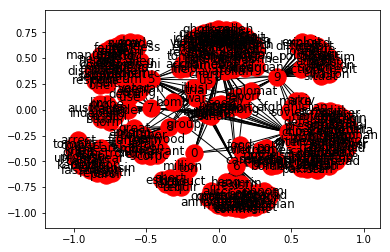

In [29]:
nx.draw_networkx(g_2mode)

In [31]:
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [32]:
gDoc = contractNetwork(g_2mode, 'doc')

In [33]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 45
Average degree:   9.0000
